In [1]:
import sys
import arviz as az
import pandas as pd 
import numpy as np
import pickle
import seaborn as sns
sys.path.append('../Advanced-statistics/modules/')
from analysis_plot import *
from utils import *
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image 


%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

#  Analytical solution of the SCIR model at low fraction of infected individuals

The SCIR model includes the usual states of an SIR model plus a new class C for individuals
sent to confinement that are susceptible but not infected.

## Fit ending before peak data for the daily number of active cases
fit from 2020-02-24 to 2020-03-29 with confinement measure aplied on 2020-03-09

# Dataset Italy
The data is taken from Protezione Civile site, starting from 2020.02.24.

In [ ]:
def doubling_time(N0, tau_d, t):
    return N0 + t / tau_d * np.log(2)


plt.plot(pd.to_datetime(df.Day), np.log(df.Active_cases_smooth) / np.log(10), 'bo-', lw=2, markersize=3, mfc='b', mec='k', label='Active cases')
#plt.plot(pd.to_datetime(df.Day)[:15], doubling_time(res_1['I0'], 1./0.24, np.arange(15)))
ymin, ymax = plt.ylim()
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.09.05']), ymin, ymax, color='g')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.10.10']), ymin, ymax, color='r')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.11.27']), ymin, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.grid()
#plt.xlim(pd.to_datetime(df.Day[df.Day == '2020.09.01']), pd.to_datetime(df.Day[df.Day == '2020.11.20']))
#plt.savefig("active_cases_data_Spain.png", quality=100, transparent=True, dpi=400)
#plt.xlim(pd.to_datetime(df.Day)[0], pd.to_datetime(df.Day)[50])
plt.show()


plt.plot(pd.to_datetime(df.Day), np.log(df.Recovered_Death_smooth) / np.log(10), 'bo-', lw=1, markersize=3, mfc='b', mec='k', label='Recovered_Death new dayly cases')
ymin, ymax = plt.ylim()
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.09.01']), ymin, ymax, color='g')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.10.10']), ymin, ymax, color='r')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.11.27']), ymin, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Dayly variation of recovered+dead cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.grid()
#plt.xlim(pd.to_datetime(df.Day)[0], pd.to_datetime(df.Day)[10])
#plt.savefig("recovered_death_data_Spain.png", quality=100, transparent=True, dpi=400)
plt.show()

In [15]:
def R_inf_less_one(res):
    "Only meanfull for before peak fits"
    f, t = np.unique((res['rmu'] * (res['p'] + res['q'])) > (res['beta'] * res['p']), return_counts=True)[1]
    return t / (t + f)


def summary(res):
    def median_sd(x):
        median = np.percentile(x, 50)
        sd = np.sqrt(np.mean((x - median) ** 2))
        return sd

    func_dict = {
        "median": lambda x: np.percentile(x, 50),
        "median_std": median_sd,
        "2.5%_hdi": lambda x: np.percentile(x, 2.5),
        "97.5%_hdi": lambda x: np.percentile(x, 97.5),
    }

    subset = {key: value for key, value in res.items() if key in ['beta', 'rmu', 'q', 'p', 'tauI', 'tauX']}
    idata = az.from_pyjags(subset)
    param = az.summary(idata, round_to=4, var_names=['beta', 'rmu', 'q', 'p', 'tauI', 'tauX'],
                        stat_funcs=func_dict)
    return param[['median', 'sd', '2.5%_hdi', '97.5%_hdi', 'r_hat']]


def var_and_error(res):
    tauI = res['tauI'].ravel()
    std_I = np.power(tauI, -1/2)
    sd_std_I = np.std(std_I)
    std_I = np.median(std_I)

    tauX = res['tauX'].ravel()
    std_X = np.power(tauX, -1/2)
    sd_std_X = np.std(std_X)
    std_X = np.median(std_X)

    print('std_I, sd_std_I, std_X, sd_std_X')
    return std_I, sd_std_I, std_X, sd_std_X


def R_inf(res):
    beta = np.median(res['beta'])
    rmu = np.median(res['rmu'])
    p = np.median(res['p'])
    q = np.median(res['q'])
    return beta * p / ( rmu * (p + q) )

## Fit ending before peak data
fit from 2020-02-27 to 2020-03-29 with confinement measure aplied on 2020-03-11

In [4]:
filehandler = open('../Advanced-statistics/Results/ita/first_wave/results_before_peak_ita.pkl', 'rb')
res_1 = pickle.load(filehandler)

In [5]:
R_inf_less_one(res_1)

0.531296

In [6]:
summary(res_1)

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.2416,0.0025,0.2368,0.2468,1.0001
rmu,0.0287,0.0019,0.0253,0.0327,1.0001
q,0.0469,0.0026,0.0434,0.0536,1.0003
p,0.0059,0.0063,0.0002,0.0233,1.0003
tauI,319.6641,79.5885,189.3054,499.7330,1.0000
tauX,6.5936,1.5849,3.9820,10.1682,1.0000


In [8]:
var_and_error(res_1)

std_I, sd_std_I, std_X, sd_std_X


(0.055931062994969596,
 0.007152304593560988,
 0.3894378950933695,
 0.04796694040568634)

In [ ]:
R_inf_less_one(res_1)

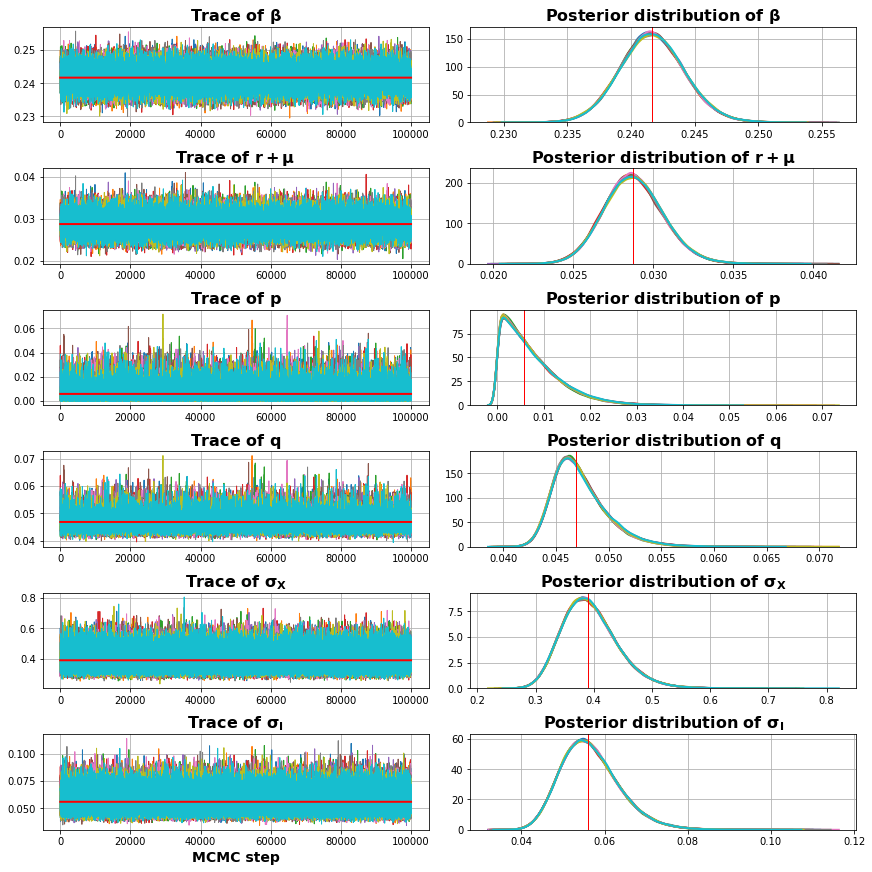

In [9]:
plot_summary(res_1)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/plot_summary_before_peak_ita.png", quality=100, transparent=True, dpi=400)

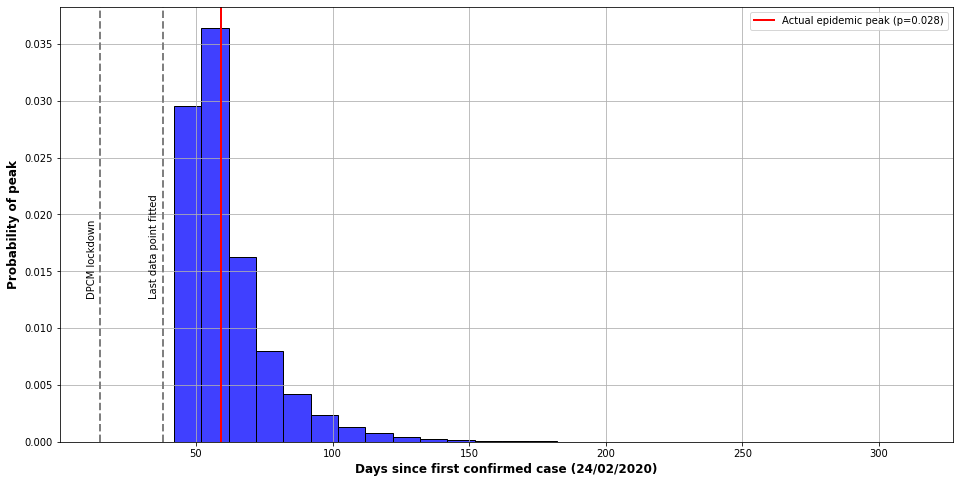

In [11]:
peak_posterior(res_1, offset=5)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/peak_posterior.png", quality=100, transparent=True, dpi=400)

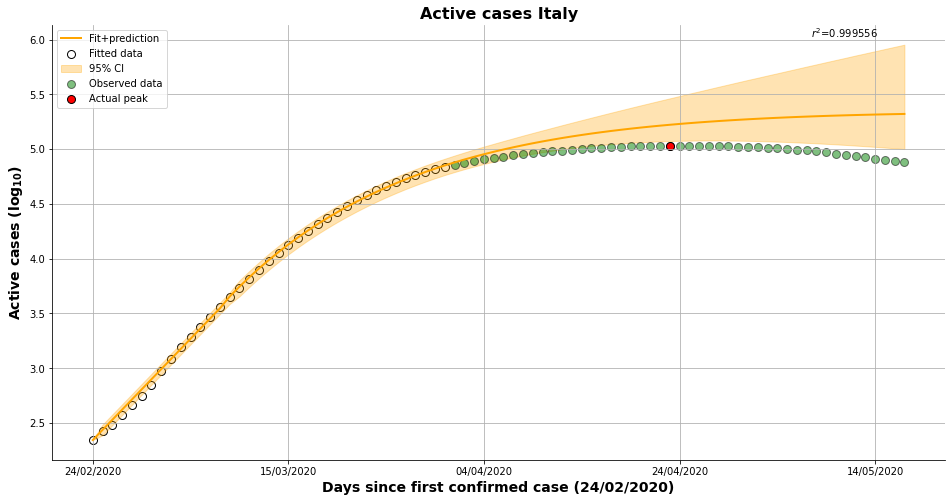

In [7]:
plot_results(res_1, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/active_cases_before.png", quality=100, transparent=True, dpi=400)

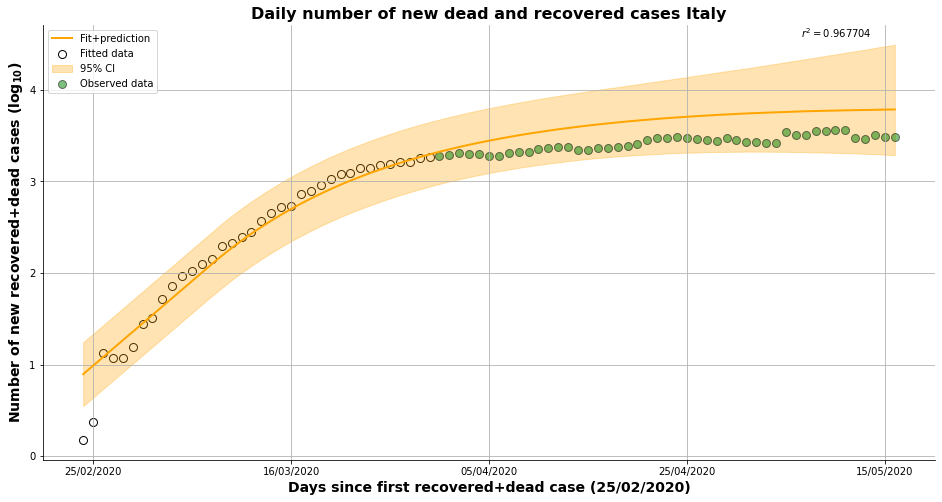

In [8]:
plot_results(res_1, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/death_recovered_before.png", quality=100, transparent=True, dpi=400)

## Fit ending after peak data for the daily number of active cases

In [4]:
filehandler = open('../Advanced-statistics/Results/ita/first_wave/results_after_peak_ita.pkl', 'rb')
res_2 = pickle.load(filehandler)

In [11]:
summary(res_2)

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.2434,0.0018,0.2399,0.2469,1.0001
rmu,0.0274,0.0012,0.0252,0.0299,1.0001
q,0.0493,0.0008,0.0478,0.0508,1.0001
p,0.0002,0.0003,0.0000,0.0012,1.0000
tauI,344.3417,66.9322,230.1135,491.4970,1.0000
tauX,9.4860,1.7963,6.4013,13.4187,1.0000


In [12]:
var_and_error(res_2)

std_I, sd_std_I, std_X, sd_std_X


(0.05388963184241346,
 0.005319141641614551,
 0.32468226484576057,
 0.031246904914438715)

In [32]:
len(df.Day[:len(states[2][::100])]), len(states[2][::100])


(83, 83)

(-10.0, 200.0)

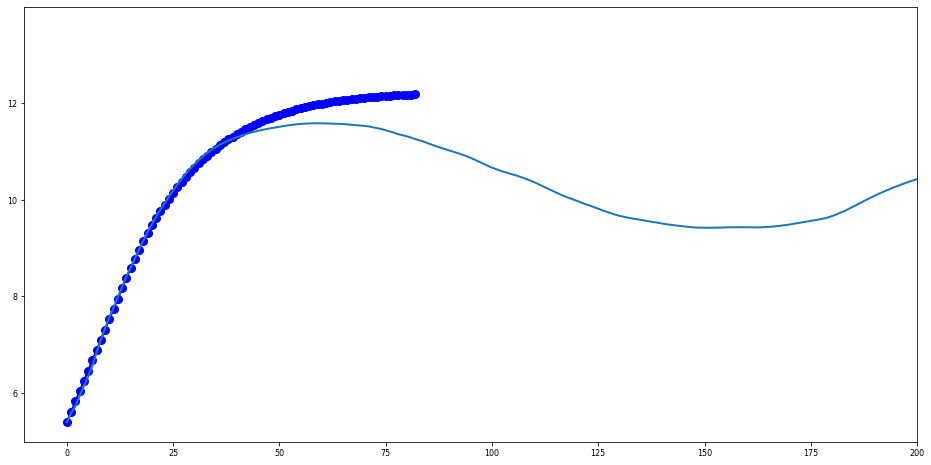

In [30]:
t, *states = solve_SCIR(res_1)


plt.plot(t[::100], np.log(states[2][::100]), 'bo-')
plt.plot(res_1['I'])
plt.xlim(-10, 200)

0.19804205158855578
2020.10.13


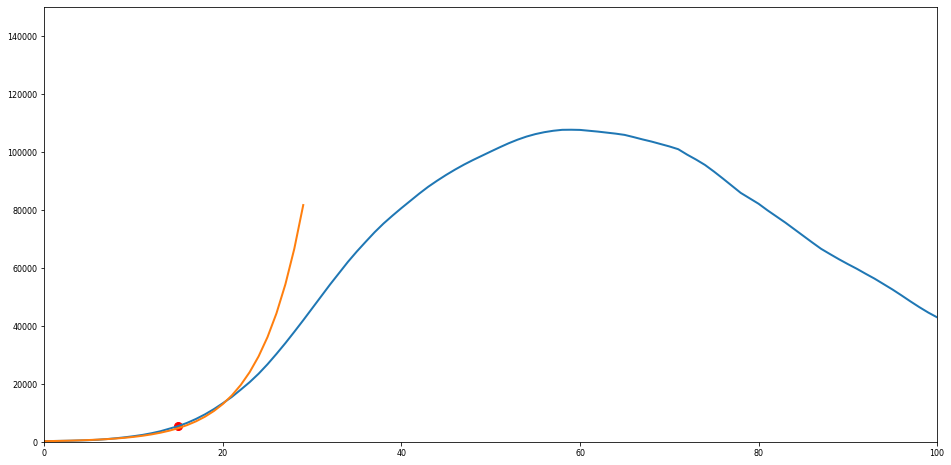

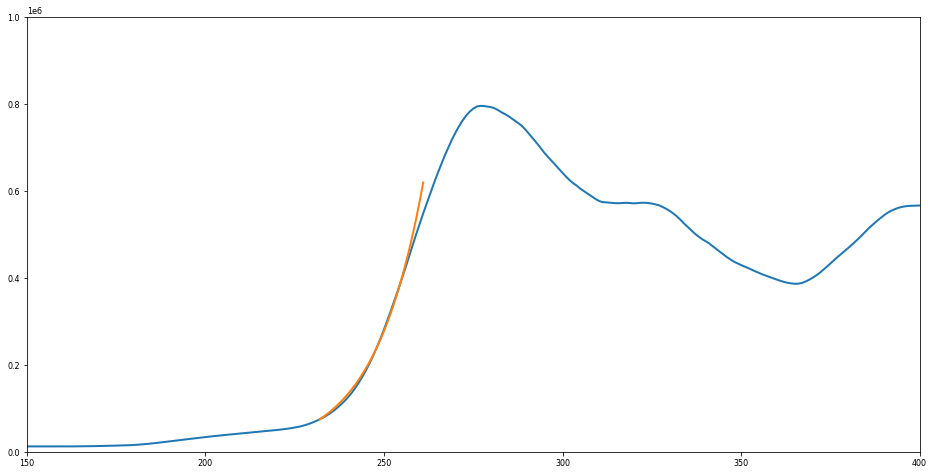

In [73]:
def doubling_time(N0, tau_d, t):
    return N0 *  np.exp(t / tau_d * np.log(2.))

print(np.log(2.) / 3.5)
print(res_2['date'][232])

plt.plot(np.exp(res_2['I']))
plt.plot(np.arange(30), doubling_time(np.exp(res_2['I0']), 3.4, np.arange(30)))
plt.scatter(res_2['tq'], np.exp(res_2['I'][res_2['tq']]), c='r')
plt.xlim(0, 100)
plt.ylim(0, 1.5e5)
plt.show()


popt, pcov = curve_fit(fit_time, x, y)l
plt.plot(np.exp(res_2['I']))
plt.plot(232 + np.arange(30), doubling_time(np.exp(res_2['I'][232]), 9.5, np.arange(30)))
plt.xlim(150, 400)
plt.ylim(0, 1e6)
plt.show()

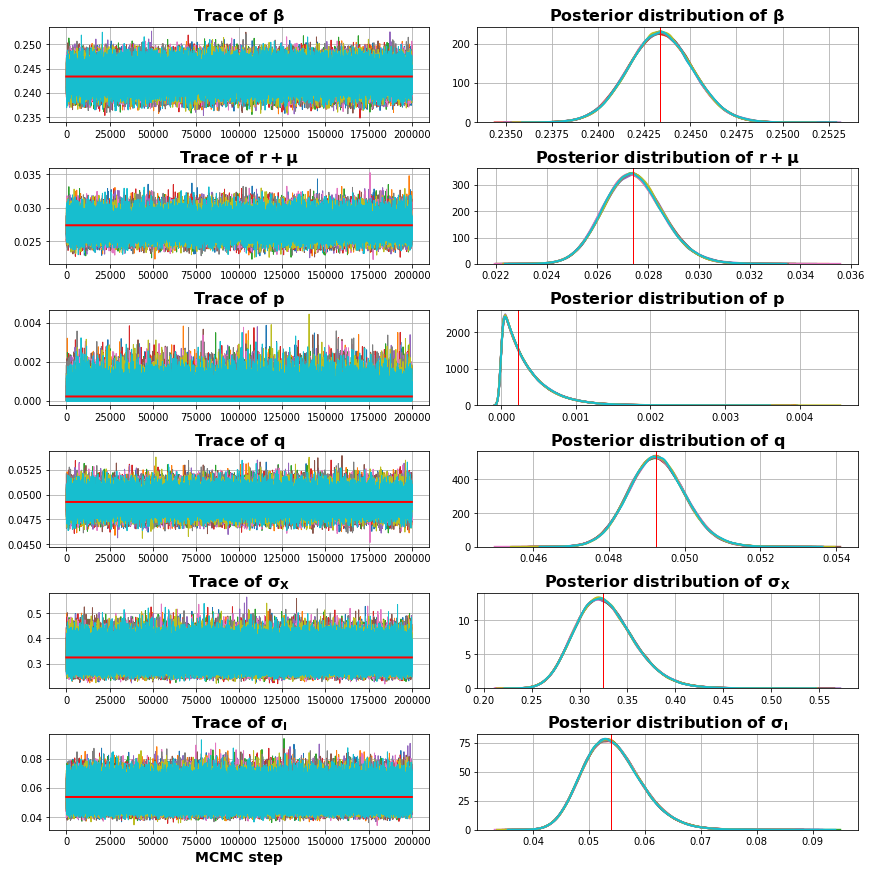

In [13]:
plot_summary(res_2)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/plot_summary_after_peak_ita.png", quality=100, transparent=True, dpi=400)

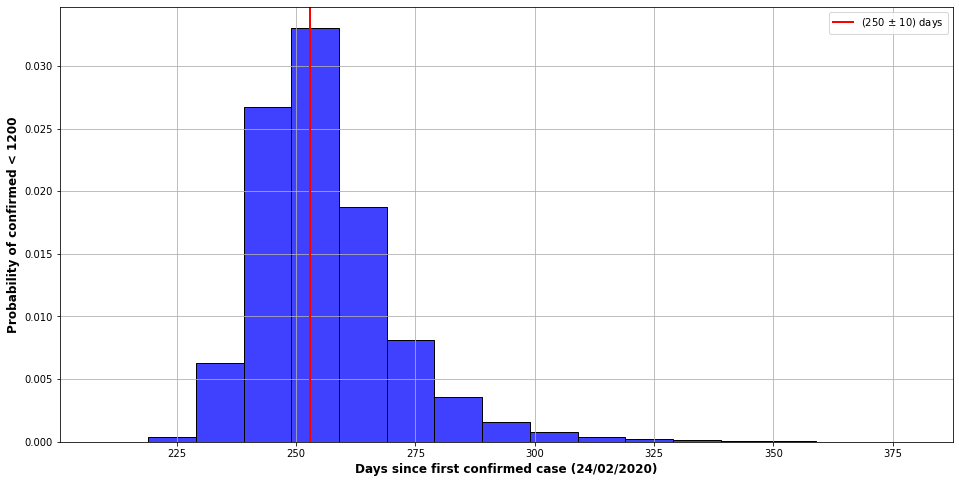

In [5]:
end_epidemic_plot(res_2, '2021.03.01')
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/end_epidemic_posterior.png", quality=100, transparent=True, dpi=400)

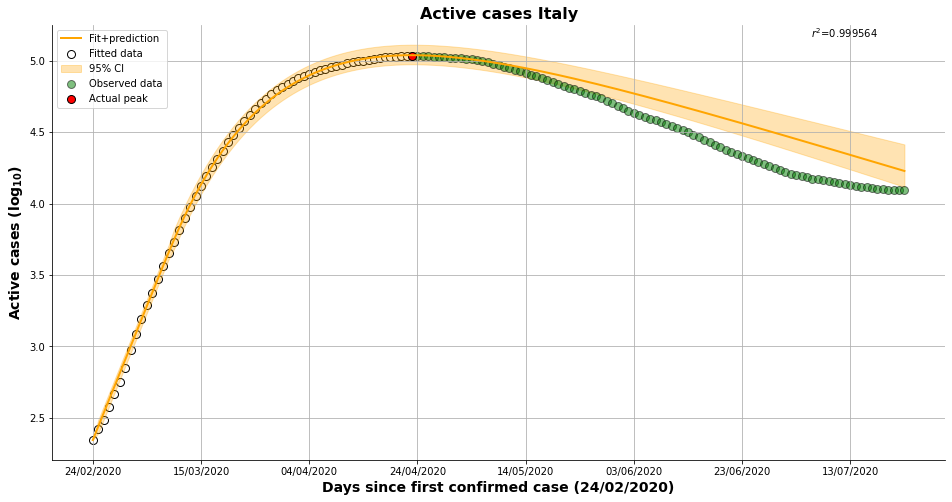

In [6]:
plot_results(res_2, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

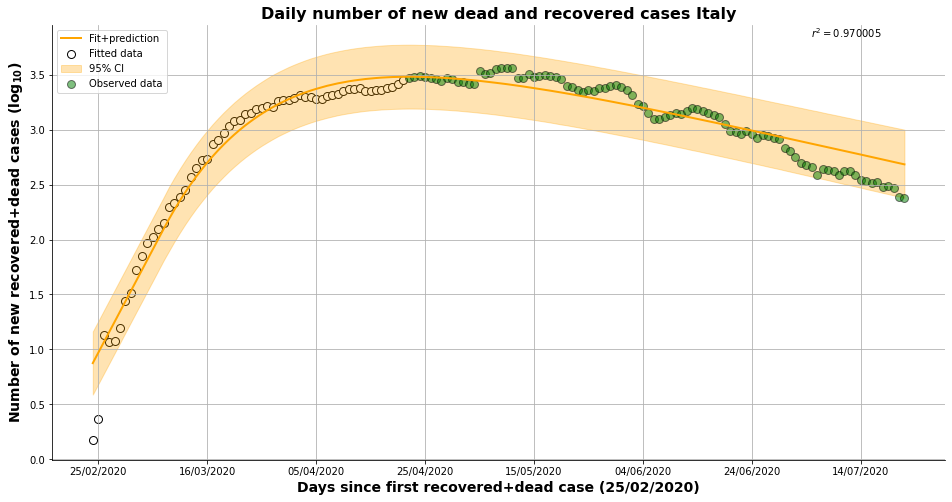

In [7]:
plot_results(res_2, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/death_recovered_after.png", quality=100, transparent=True, dpi=400)

In [4]:
filehandler = open('../Advanced-statistics/Results/ita/second_wave/results_before_peak_ita_good.pkl', 'rb')
res_3 = pickle.load(filehandler)

In [5]:
summary(res_3)

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.0844,0.0008,0.0829,0.0859,1.0
rmu,0.0147,0.0004,0.0140,0.0154,1.0
q,0.9288,0.5547,0.1705,2.2771,1.0
p,3.4431,1.2452,0.5633,4.9328,1.0
tauI,356.0534,94.0343,203.8264,570.4141,1.0
tauX,53.6047,13.6806,31.2790,84.6579,1.0


In [19]:
R_inf_less_one(res_3) * 100

0.062049999999999994

In [7]:
var_and_error(res_3)

std_I, sd_std_I, std_X, sd_std_X


(0.05299591759259499,
 0.007215914745173744,
 0.13658356510486272,
 0.017942801522365145)

In [16]:
R_inf(res_3)

4.527698888586084

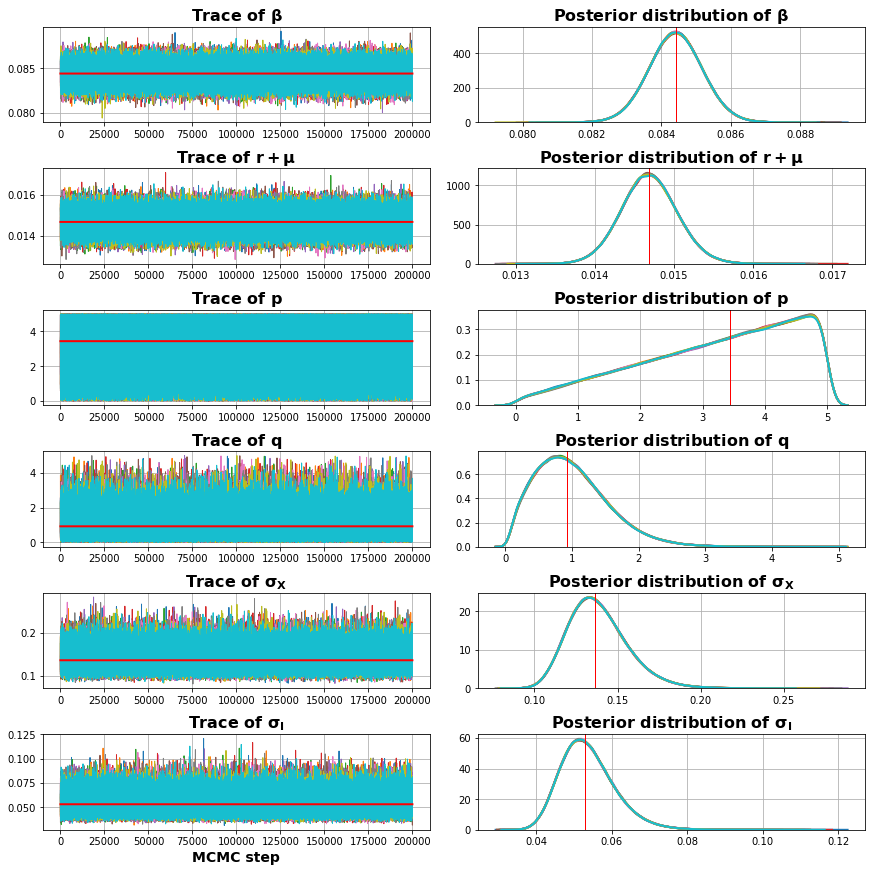

In [9]:
plot_summary(res_3)
plt.savefig("../Advanced-statistics/Results/ita/second_wave/plot/plot_summary_before_peak_ita.png", quality=100, transparent=True, dpi=400)

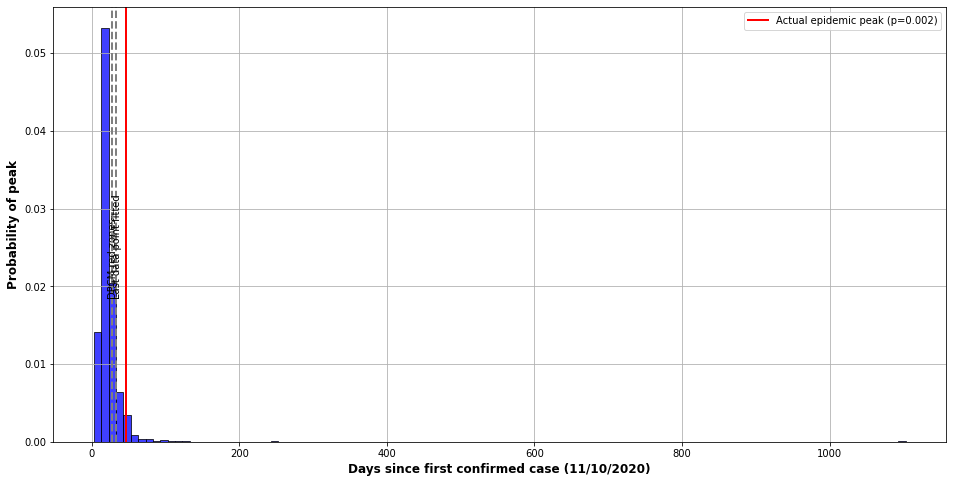

In [10]:
peak_posterior(res_3, offset=5, second_wave=True);

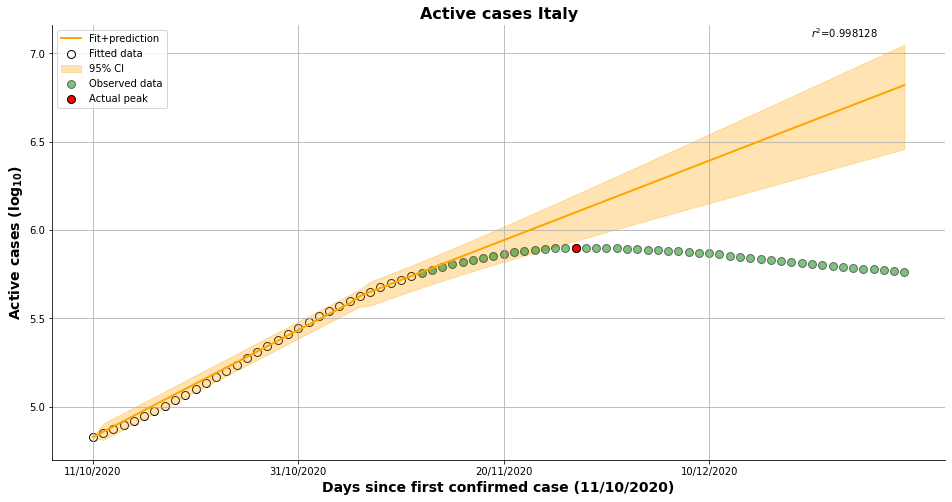

In [17]:
plot_results(res_3, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/second_wave/plot/active_cases_before.png", quality=100, transparent=True, dpi=400)

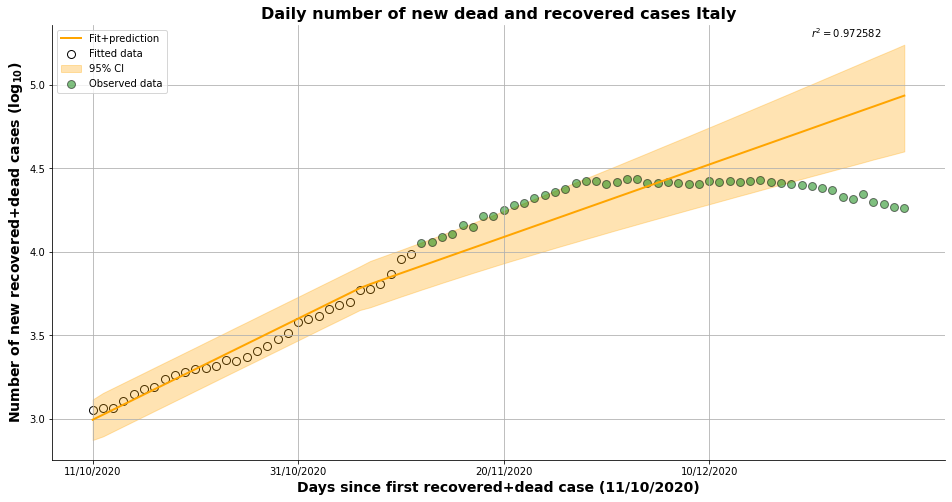

In [18]:
plot_results(res_3, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/second_wave/plot/death_recovered_before.png", quality=100, transparent=True, dpi=400)

In [50]:
R_inf(res_3)

4.680372471912752

In [20]:
filehandler = open('../Advanced-statistics/Results/ita/second_wave/results_after_peak_ita_good.pkl', 'rb')
res_4 = pickle.load(filehandler)

In [21]:
summary(res_4)

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.0869,0.0009,0.0852,0.0888,1.0000
rmu,0.0172,0.0007,0.0159,0.0187,1.0000
q,0.0858,0.0166,0.0668,0.1284,1.0005
p,0.0406,0.0308,0.0037,0.1181,1.0005
tauI,512.9205,111.6001,325.1789,761.3506,1.0000
tauX,12.8476,2.6870,8.3012,18.7965,1.0000


In [22]:
var_and_error(res_4)

std_I, sd_std_I, std_X, sd_std_X


(0.04415449926301504,
 0.004910826341314883,
 0.2789900453841193,
 0.0297610915812815)

In [27]:
R_inf(res_4)

1.6220686221135818

In [29]:
R_inf_less_one(res_4) * 100

17.84855

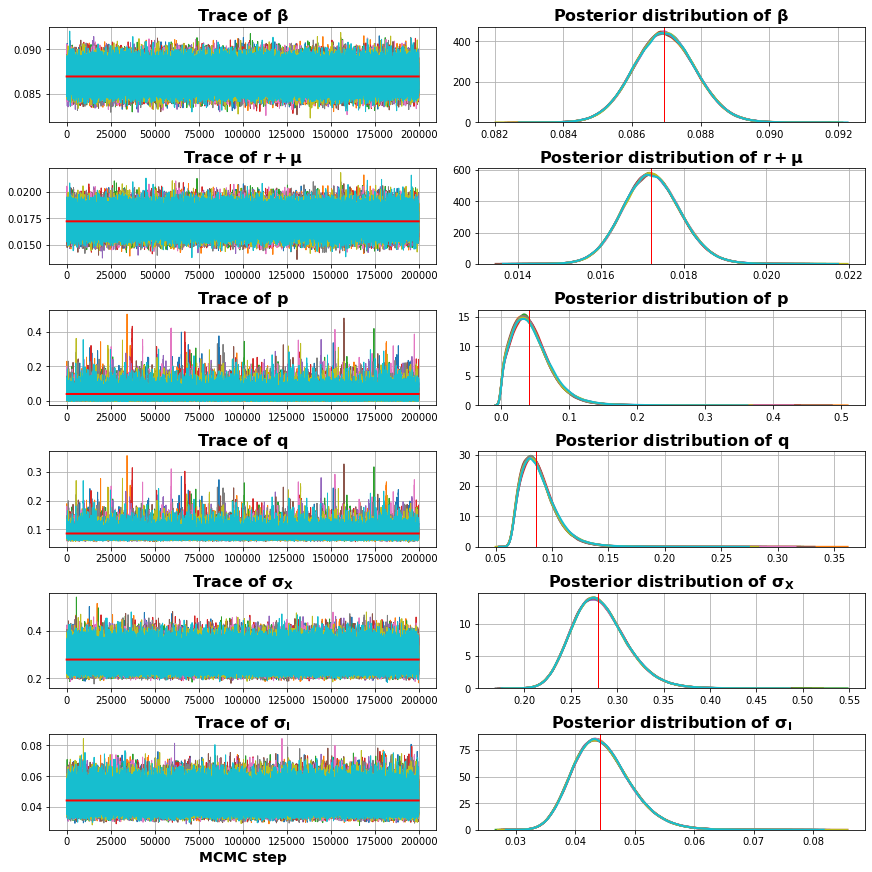

In [23]:
plot_summary(res_4)
plt.savefig("../Advanced-statistics/Results/ita/second_wave/plot/plot_summary_after_peak_ita.png", quality=100, transparent=True, dpi=400)

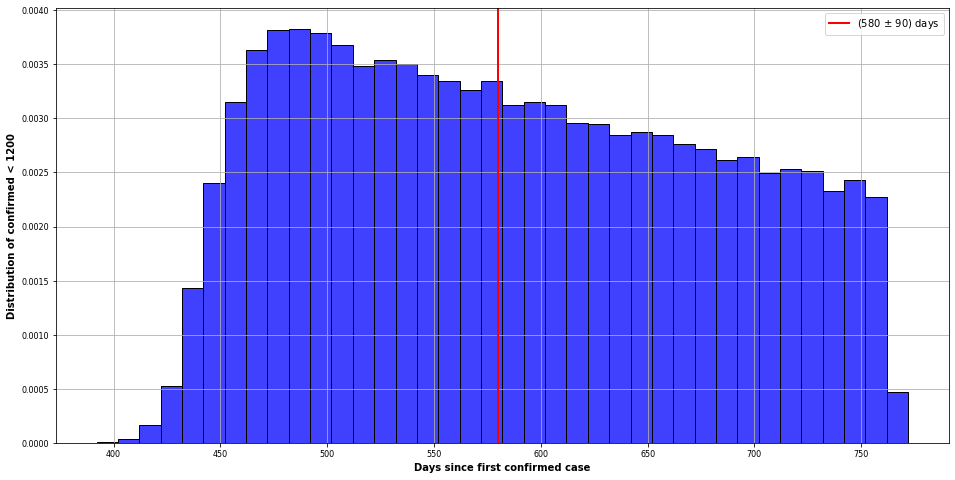

In [72]:
end_epidemic_plot(res_4, '2022.11.14')

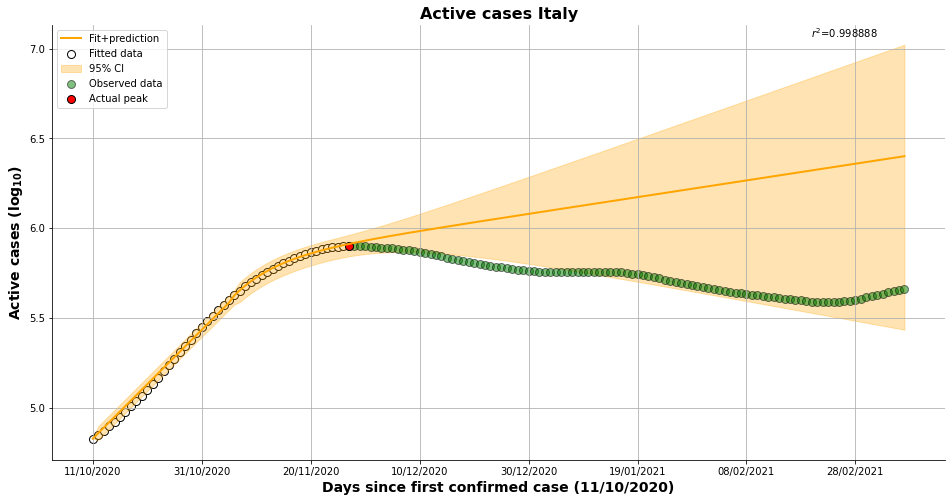

In [24]:
plot_results(res_4, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/second_wave/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

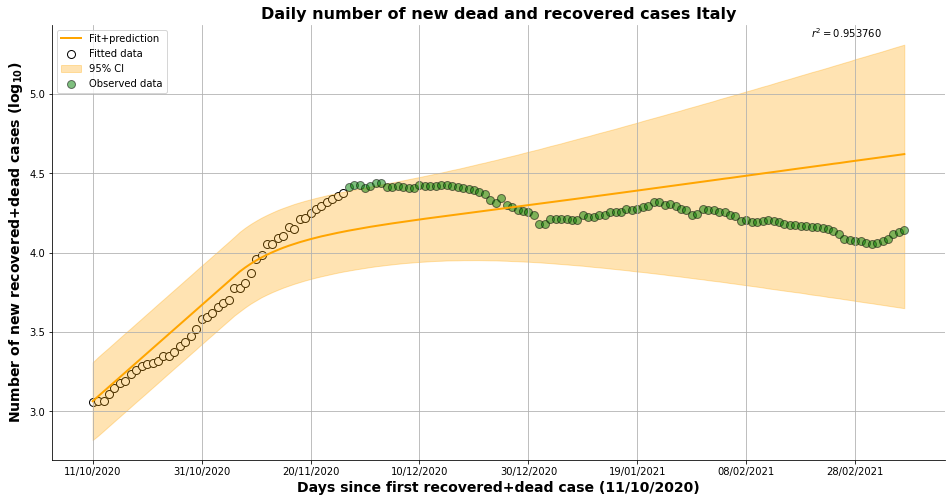

In [25]:
plot_results(res_4, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/second_wave/plot/death_recovered_after.png", quality=100, transparent=True, dpi=400)

In [62]:
filehandler = open('../Advanced-statistics/Results/fra/first_wave/results_before_peak_fra.pkl', 'rb')
res_5 = pickle.load(filehandler)

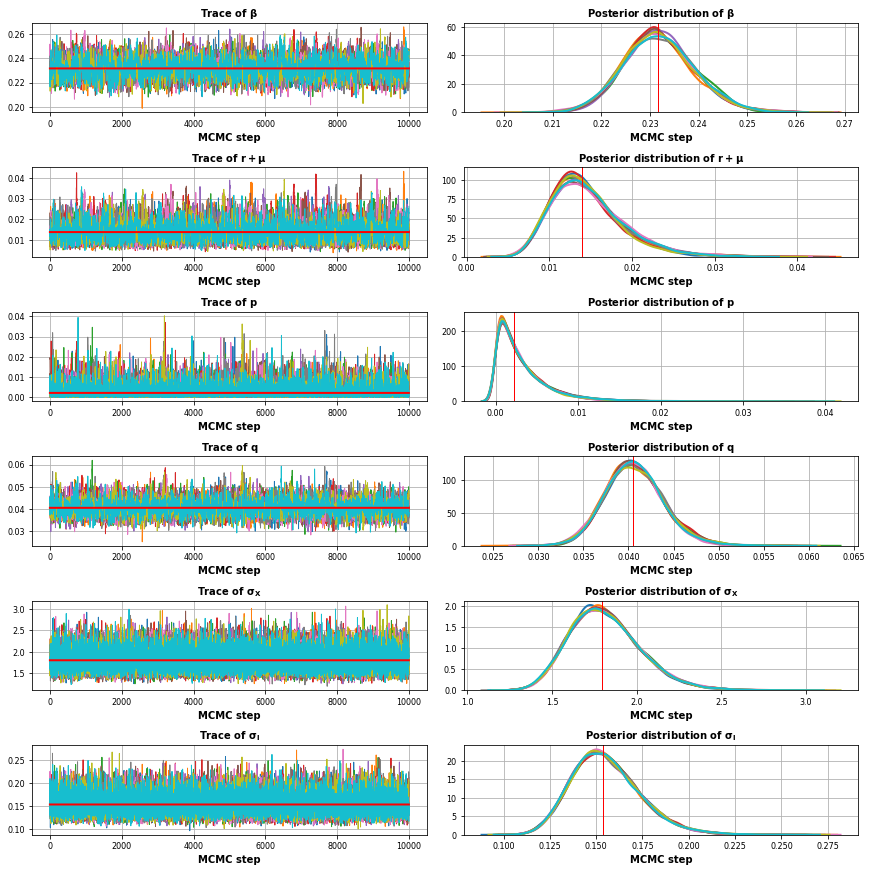

In [54]:
plot_summary(res_5)
#plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/plot_summary_before_peak_ita.png", quality=100, transparent=True, dpi=400)

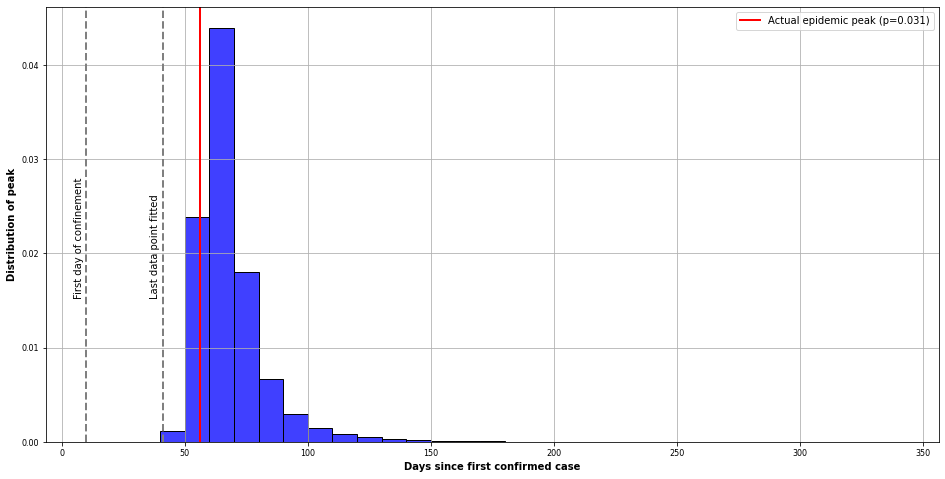

In [57]:
peak_posterior(res_5, offset=5)
plt.grid()
#plt.savefig("../Advanced-statistics/Results/fra/first_wave/plot/peak_posterior.png", quality=100, transparent=True, dpi=400)

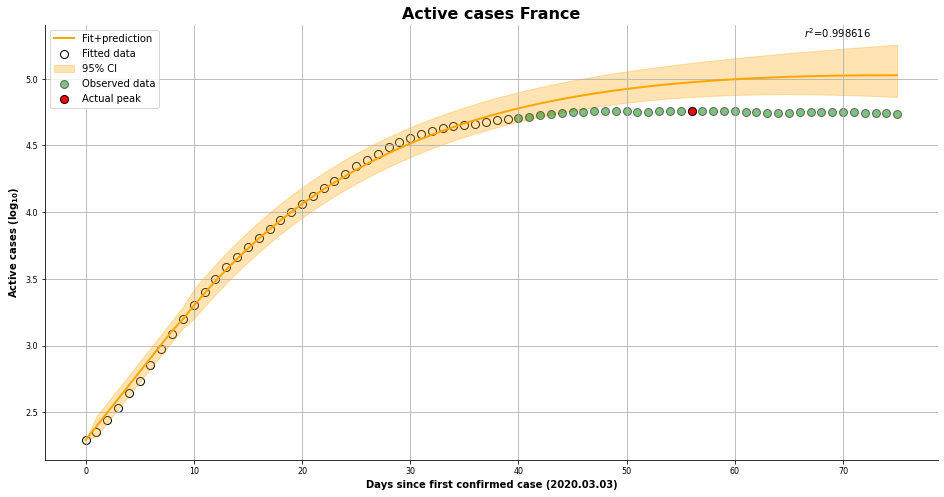

In [58]:
plot_results(res_5, ci=95, Y=True, Z=False, observed=True)
#plt.savefig("../Advanced-statistics/Results/fra/first_wave/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

In [63]:
filehandler = open('../Advanced-statistics/Results/fra/first_wave/results_after_peak_fra.pkl', 'rb')
res_6 = pickle.load(filehandler)

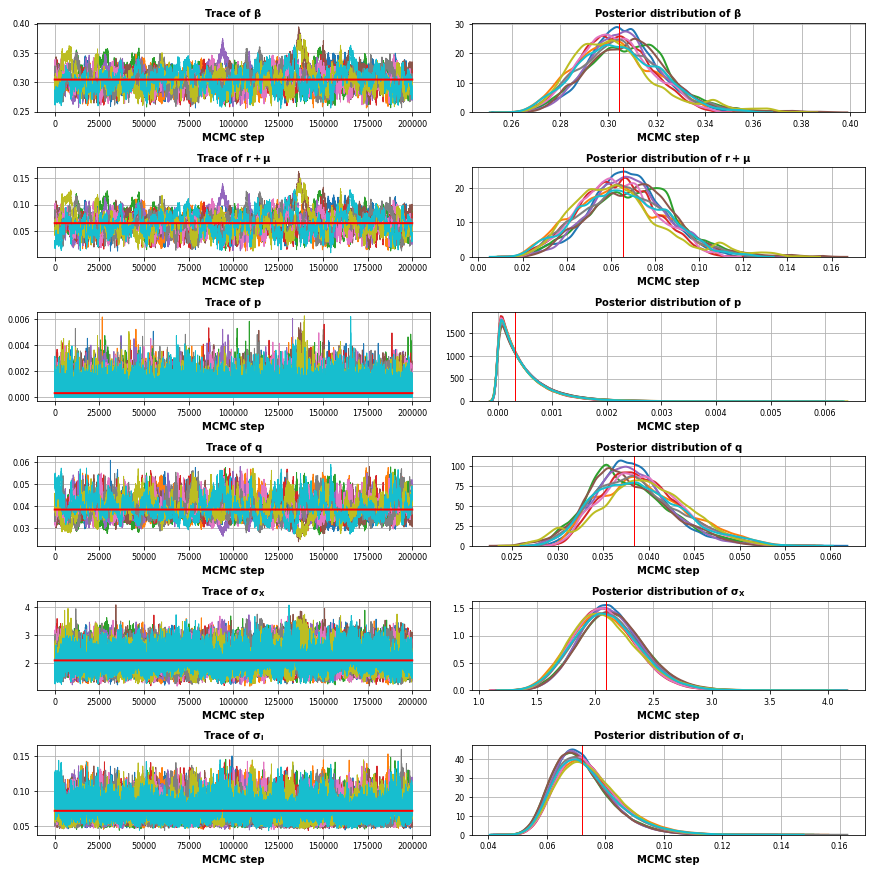

In [64]:
plot_summary(res_6)
#plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/plot_summary_after_peak_ita.png", quality=100, transparent=True, dpi=400)

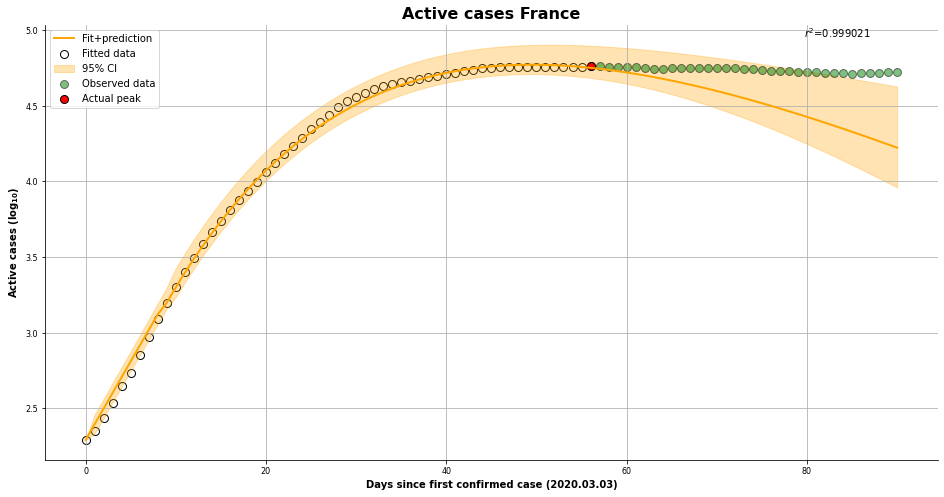

In [65]:
plot_results(res_6, ci=95, Y=True, Z=False, observed=True)
#plt.xlim(0, 90)
#plt.savefig("../Advanced-statistics/Results/fra/first_wave/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

In [3]:
filehandler = open('../Advanced-statistics/Results/esp/results_before_peak_esp.pkl', 'rb')
res_8 = pickle.load(filehandler)

In [13]:
print(var_and_error(res_8))

summary(res_8)

std_I, sd_std_I, std_X, sd_std_X
(0.13234200884743744, 0.01955454105820908, 1.1424682102759292, 0.1784270888174264)


,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.3697,0.0081,0.3552,0.3870,1.0015
rmu,0.0204,0.0052,0.0128,0.0330,1.0016
q,0.0551,0.0049,0.0479,0.0668,1.0027
p,0.0070,0.0095,0.0003,0.0346,1.0020
tauI,57.0959,16.2716,31.1425,94.9077,1.0002
tauX,0.7661,0.2300,0.4053,1.3026,1.0001


In [4]:
f, t = np.unique((res_8['rmu'] * (res_8['p'] + res_8['q'])) > (res_8['beta'] * res_8['p']), return_counts=True)[1]
t / (t + f)

0.26742

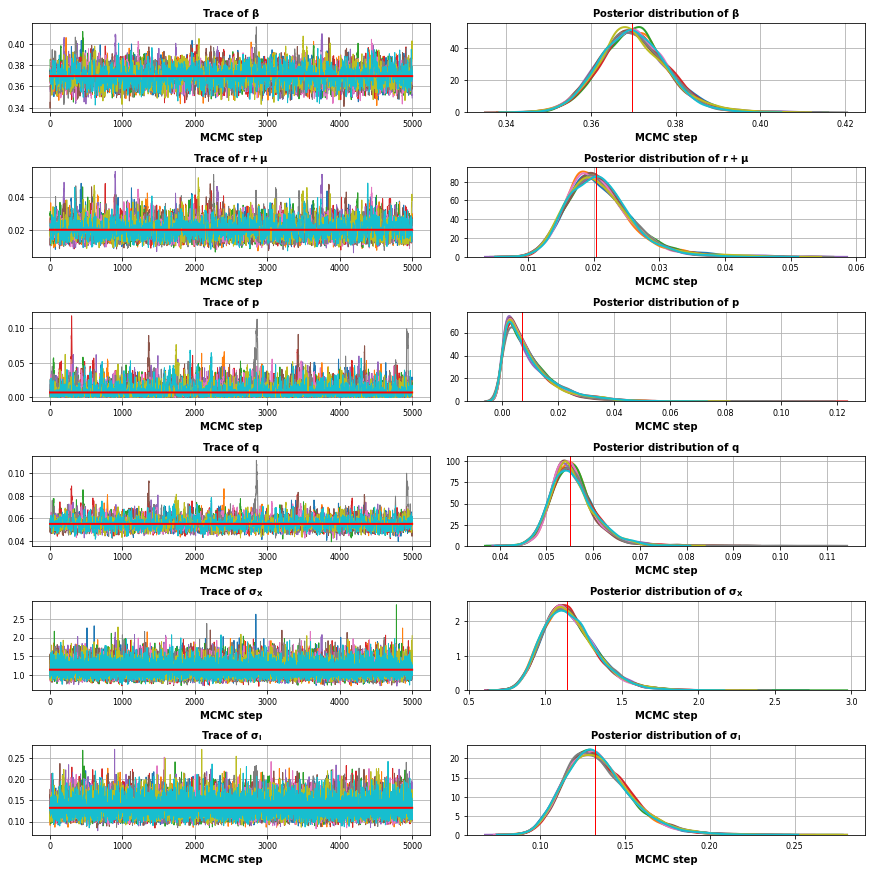

In [5]:
plot_summary(res_8)
plt.savefig("../Advanced-statistics/Results/esp/plot/plot_summary_before_peak_esp.png", quality=100, transparent=True, dpi=400)

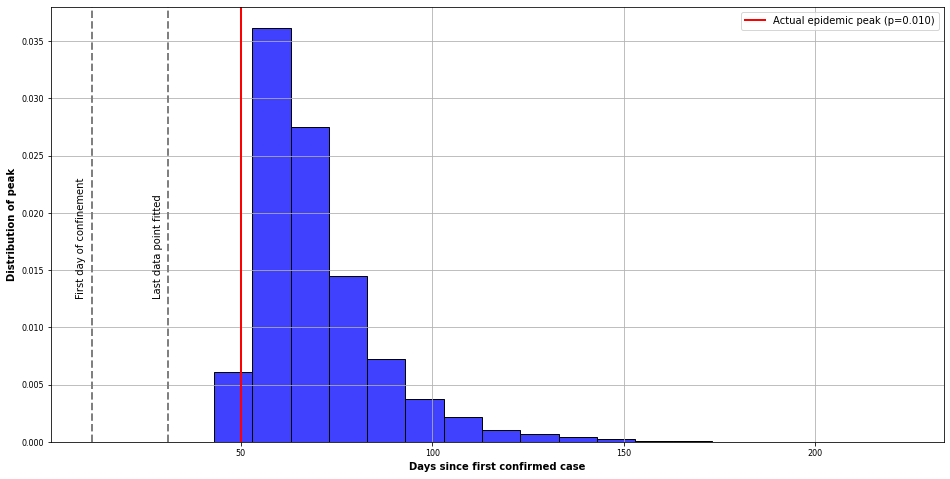

In [7]:
peak_posterior(res_8, offset=4)
plt.grid()
plt.savefig("../Advanced-statistics/Results/esp/plot/peak_posterior.png", quality=100, transparent=True, dpi=400)

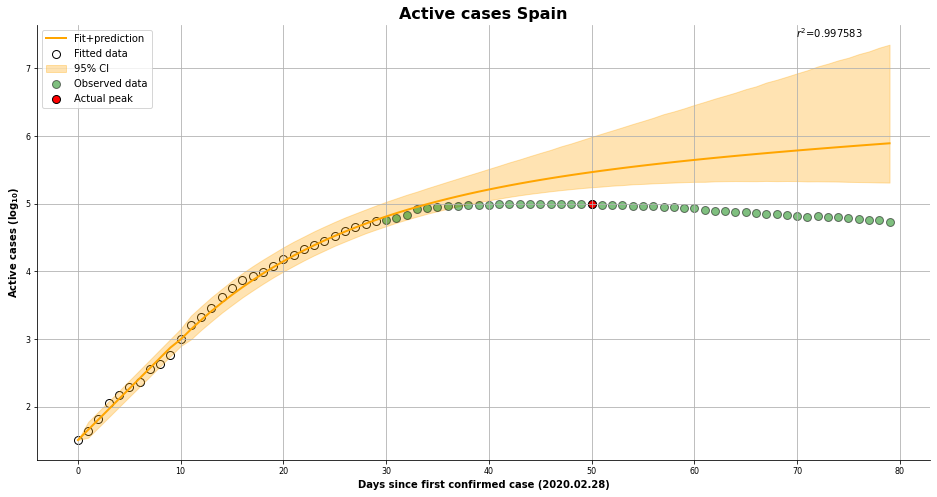

In [14]:
plot_results(res_8, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/esp/plot/active_cases_before.png", quality=100, transparent=True, dpi=400)

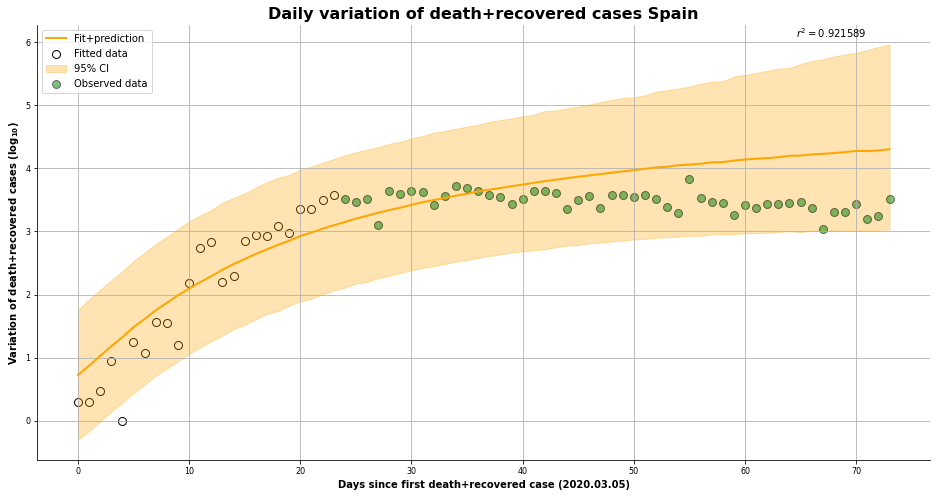

In [15]:
plot_results(res_8, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/esp/plot/death_recovered_before.png", quality=100, transparent=True, dpi=400)

In [16]:
filehandler = open('../Advanced-statistics/Results/esp/results_after_peak_esp.pkl', 'rb')
res_9 = pickle.load(filehandler)

In [17]:
print(var_and_error(res_9))

summary(res_9)

std_I, sd_std_I, std_X, sd_std_X
(0.13914277570703493, 0.020103414726478242, 0.9783779037168354, 0.49702296416434916)


,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.3987,0.0702,0.3843,0.6683,1.2601
rmu,0.0332,0.0746,0.0241,0.3190,1.2683
q,0.0594,0.0095,0.0265,0.0642,1.2650
p,0.0004,0.0021,0.0000,0.0088,1.2293
tauI,51.6510,19.8607,31.8416,115.3979,1.2281
tauX,1.0447,0.3680,0.1300,1.6247,1.2494


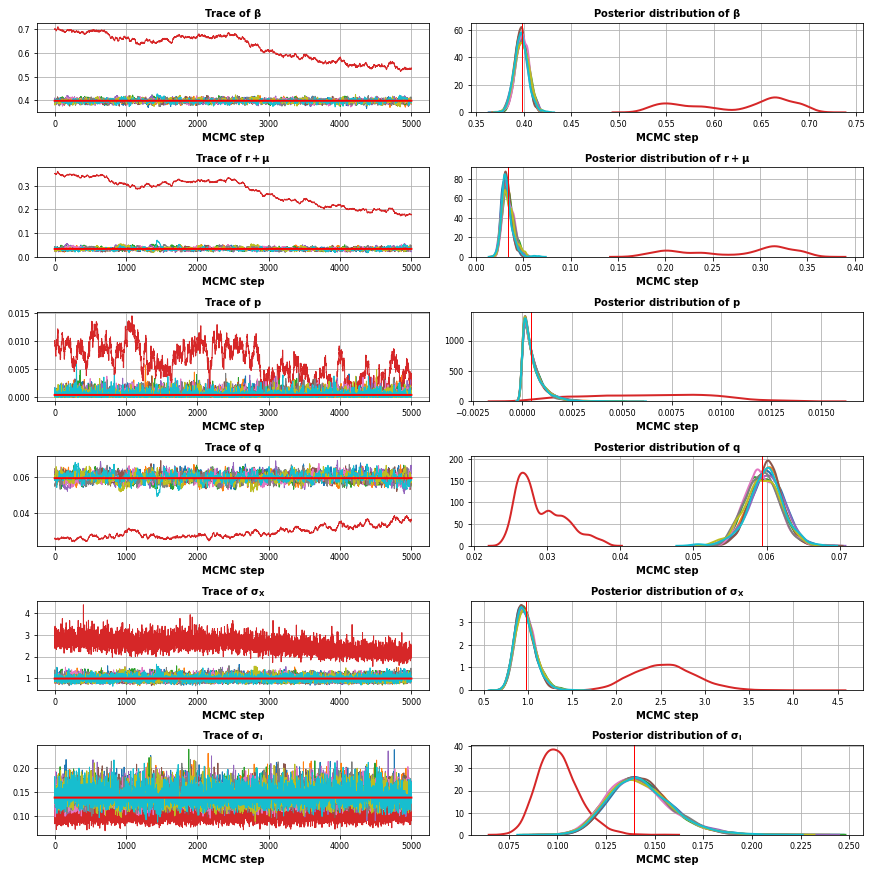

In [18]:
plot_summary(res_9)
plt.savefig("../Advanced-statistics/Results/esp/plot/plot_summary_after_peak_esp.png", quality=100, transparent=True, dpi=400)

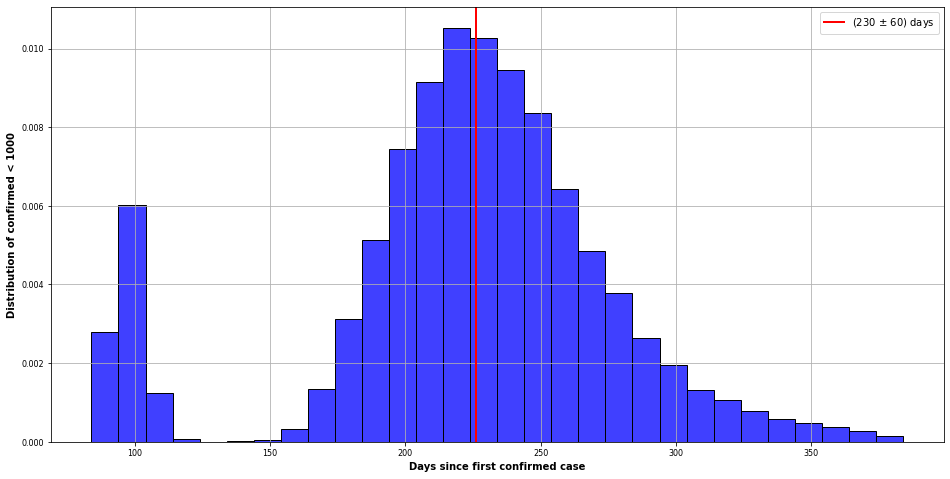

In [19]:
end_epidemic_plot(res_9, '2021.03.14')
plt.savefig("../Advanced-statistics/Results/esp/plot/end_epidemic_posterior.png", quality=100, transparent=True, dpi=400)

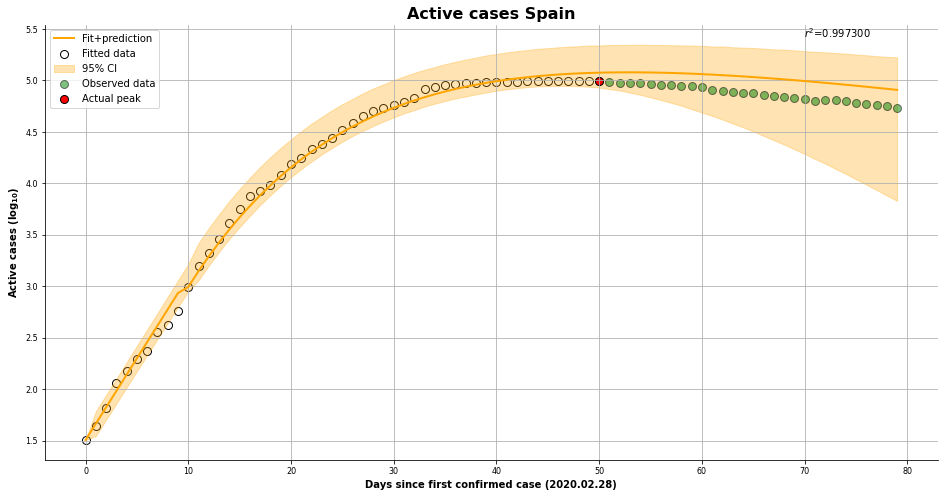

In [20]:
plot_results(res_9, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/esp/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

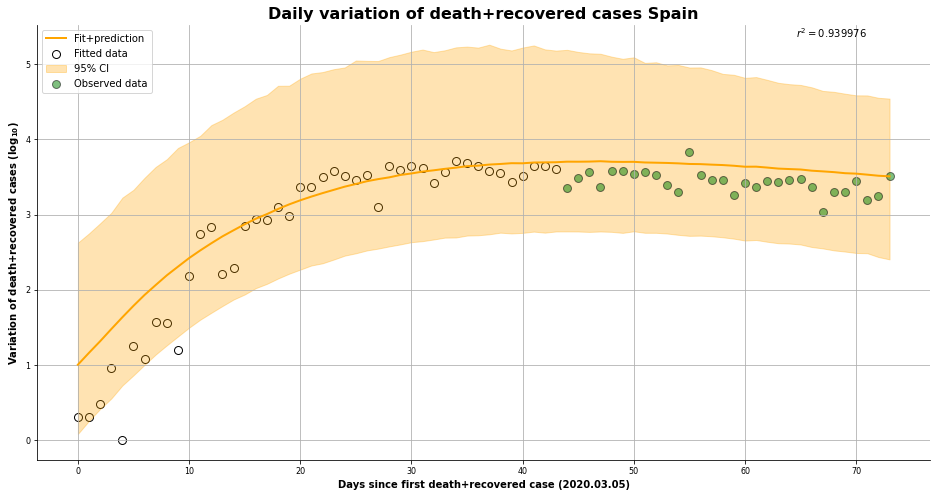

In [21]:
plot_results(res_9, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/esp/plot/death_recovered_after.png", quality=100, transparent=True, dpi=400)